### Icevision Inference and Evalutation

This notebook walks through the steps to load a portable torchscript model with torch and run inference on our validation set (or test set)

Loading a Torchscript scripting model. Torchvision is required to load the model, it does a global import in the background to include the NMS operation that Mask-R-CNN needs.

Reminder: if this cell is failing, remember to mount the GCP buckets with `cdata` and `cdata2`

In [ ]:
from pycocotools.cocoeval import COCOeval
from ceruleanml.coco_stats import all_sample_stat_lists
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from ceruleanml import preprocess
from ceruleanml import data
from icevision import models, parsers, show_records, tfms, Dataset, Metric, COCOMetric, COCOMetricType
import numpy as np
from ceruleanml.inference import apply_conf_threshold_instances, apply_conf_threshold_masks

import torch
import torchvision
icevision_experiment_dir = "/root/data/experiments/cv2/20_Jul_2022_00_14_15_icevision_maskrcnn"
scripted_model = torch.jit.load(f"{icevision_experiment_dir}/scripting_cpu_test_28_34_224_58.pt")

In [ ]:
torchvision.__version__

In [ ]:
torch.__version__

Setting up our Icevision record collection for the validation dataset. We remap vessel slick classes to only have one vessel slick class, remove ambiguous and remove natural seep samples.

In [ ]:
run_list = [[224, 30]]*1 # List of tuples, where the tuples are [px size, training time in minutes]
# run_list = [[64, 1]]*1+[[128, 1]]*1+[[224, 1]]*1 +[[512, 1]]*1
init_size = run_list[0][0]
negative_sample_count = 0
negative_sample_count_val = 0
area_thresh = 0

In [ ]:
data_path = "/root/"
mount_path = "/root/data"

val_set = "val-with-context-512"
tiled_images_folder_val= "tiled_images"
json_name_val = "instances_TiledCeruleanDatasetV2.json"
coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"
remove_list=["ambiguous", "natural_seep"]
class_names_to_keep=[
            "background",
            "infra_slick",
            "recent_vessel",
        ]
remap_dict = {  # only remaps coincident and old to recent
            3: 4,
            5: 4,
        }

# since we remove ambiguous and natural seep and remap all vessels to 1 and include background
num_classes = 3 
class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))

record_collection_with_negative_small_filtered_val = preprocess.load_set_record_collection(
    coco_json_path_val, tiled_images_folder_val, area_thresh, negative_sample_count_val, preprocess=True, class_names_to_keep=class_names_to_keep,
    remap_dict=remap_dict, remove_list=remove_list
)
record_ids_val = record_collection_to_record_ids(record_collection_with_negative_small_filtered_val)

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=init_size)])
valid_ds = Dataset(record_collection_with_negative_small_filtered_val, valid_tfms)

You can decrease the size of the valid_ds here for faster testing

In [ ]:
#valid_ds = Dataset(record_collection_with_negative_small_filtered_val[0:3]+record_collection_with_negative_small_filtered_val[100:102]+record_collection_with_negative_small_filtered_val[-2:], valid_tfms)

Grabbing a test image to inspect

In [ ]:
test_img = valid_ds[2].img

In [ ]:
type(test_img)

We need to convert this to a pytorch tensor before running inference with the model we loaded

In [ ]:
torch.Tensor(np.moveaxis(test_img,2,0)).shape

And normalize the values to fall between 0 and 1

In [ ]:
[torch.Tensor(np.moveaxis(test_img,2,0))/255]

Finally, we need to put each sample tensor in a list, the list length is the batch dimension.

In [ ]:
len([torch.Tensor(np.moveaxis(test_img,2,0))/255])

maskrcnn wants a list of 3D arrays with length of list as batch size, Fastai Unet wants a 4D array with 0th dim as batch size

In [ ]:
losses, pred_list = scripted_model([torch.Tensor(np.moveaxis(test_img,2,0))/255])

fastai returns a 2D array of logits. logits need to be converted to confidence probabilities. Mask RCNN returns a losses array we don't use and a list of dictionaries containing detections.

In [ ]:
len(pred_list)

pred_list details
* bbox coords are not normalized. 
* dict values are tensors until post processed with conf thresholding.
* length of value list indicates how many instances detected both low and high confidence
* Mask R-CNN mask values are not logits, they are 0 to 1 confidence probabilities. the torchscript model applies softmax unlike the fastai unet model where we do that after inference.
* bbox coord order is xmin, ymin, xmax, ymax, the same as icevision record collection bbox format

In [ ]:
pred_list[0]

In [ ]:
pred_list[0]['scores']

In [ ]:
pred_list[0]['labels']

In [ ]:
pred_list[0]['masks'].shape

In [ ]:
pred_list[0]['masks']

In [ ]:
%matplotlib inline
import skimage.io as skio

In [ ]:
skio.imshow(test_img[:,:,0])

We can extract the first mask in the first sample's prediction and plot it by converting it to a numpy array.

In [ ]:
skio.imshow(pred_list[0]['masks'][0,0,:,:].detach().cpu().numpy())

TODO plot a histogram of confidence scores for a pred_list

In [ ]:
import matplotlib.pyplot as plt

test = pred_list[0]['masks'][0,0,:,:].detach().cpu().numpy().flatten()

# scratch code
# np.ma.masked_where(test!=0, test)

# plt.hist(np.ma.masked_where(test!=0, test), bins = 300)

After inference, we need to post process the result.

In [ ]:
bbox_conf_threshold = .5

pred_dict = apply_conf_threshold_instances(pred_list[0], bbox_conf_threshold=bbox_conf_threshold)

In [ ]:
apply_conf_threshold_instances??

In [ ]:
pred_dict

In [ ]:
merged_class_arr = apply_conf_threshold_masks(pred_dict, mask_conf_threshold=.05, size=224)

In [ ]:
apply_conf_threshold_masks??

The output of the last thresholding step is a 2D array of classes. we use this for pixel-wise evaluation. 

In [ ]:
merged_class_arr.shape

In [ ]:
skio.imshow(test_img[:,:,0])

In [ ]:
torch.unique(merged_class_arr)

In [ ]:
import skimage.io as skio

This array has two values, 2 for vessels and 0 for background

In [ ]:
%matplotlib inline
skio.imshow(merged_class_arr.detach().cpu().numpy())

### Fastai Inference Evaluation with a Pixel Wise confusion matrix

Like with icevision, we can run inference with a portable torchscript model. 

In [ ]:
fastai_unet_experiment_dir = "/root/data/experiments/cv2/29_Jun_2022_06_36_38_fastai_unet"

tracing_model_cpu_pth = f"{fastai_unet_experiment_dir}/tracing_cpu_224_120__512_36__4_34_0.0003_0.436.pt"

model = torch.jit.load(tracing_model_cpu_pth)

Next, we set up the data loader.

In [ ]:
from ceruleanml import data
from ceruleanml import evaluation
from ceruleanml import preprocess
import os, random
import skimage.io as skio
import numpy as np
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from torchvision.models import resnet18, resnet34, resnet50
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.data.transforms import IndexSplitter
from fastai.vision.augment import aug_transforms, Resize
from ceruleanml.inference import logits_to_classes, apply_conf_threshold

bs_d ={512:4, 256:32, 224:32, 128:64, 64:256}
lr_d = {512:3e-4, 256:1e-3, 224:3e-3, 128:3e-3, 64:1e-2}
arch_d = {18: resnet18, 34: resnet34, 50: resnet50}
class_model_file = "/root/experiments/cv2/26_Jul_2022_21_57_24_fastai_unet/tracing_cpu_test_32_34_224_0.824_30.pt"

### Parsing COCO Dataset with Icevision

# for fastai we need the train set to parse the val set with fastai dls
mount_path = "/root/"
train_set = "train-with-context-512"
tiled_images_folder_train = "tiled_images"
json_name_train = "instances_TiledCeruleanDatasetV2.json"

coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
record_collection_with_negative_small_filtered_train = preprocess.load_set_record_collection(
    coco_json_path_train, tiled_images_folder_train, area_thresh, negative_sample_count_val, preprocess=False, class_names_to_keep=class_names_to_keep,
    remap_dict=remap_dict, remove_list=remove_list
)
record_ids_train = record_collection_to_record_ids(record_collection_with_negative_small_filtered_train)

record_ids_val = record_collection_to_record_ids(record_collection_with_negative_small_filtered_val)

assert len(set(record_ids_train)) + len(set(record_ids_val)) == len(record_ids_train) + len(record_ids_val)

train_val_record_ids = record_ids_train + record_ids_val
combined_record_collection = record_collection_with_negative_small_filtered_train + record_collection_with_negative_small_filtered_val

def get_val_indices(combined_ids, val_ids):
    return list(range(len(combined_ids)))[-len(val_ids):]

### Constructing a FastAI DataBlock that uses parsed COCO Dataset from icevision parser. aug_transforms can only be used with_context=True

val_indices = get_val_indices(train_val_record_ids, record_ids_val)

def get_image_by_record_id(record_id):
    return get_image_path(combined_record_collection, record_id)

def get_mask_by_record_id(record_id):
    return record_to_mask(combined_record_collection, record_id)

coco_seg_dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=class_ints)), # ImageBlock is RGB by default, uses PIL
        get_x=get_image_by_record_id,
        splitter=IndexSplitter(val_indices),
        get_y=get_mask_by_record_id,
        # batch_tfms=batch_transfms,
        item_tfms = Resize(512),
        n_inp=1
    )

dset = coco_seg_dblock.datasets(source= record_ids_train)

We can grab a record of interest from the icevision record collection to inspect inference on a single result

In [ ]:
records_of_interest = []
for record in record_collection_with_negative_small_filtered_train:
    if "S1A_IW_GRDH_1SDV_20200724T020738_20200724T020804_033590_03E494_B457" in str(record.common.filepath):
        records_of_interest.append(record)

idx_of_interest = records_of_interest[6].common.record_id

idx = train_val_record_ids.index(idx_of_interest)

img, mask = dset[idx]

%matplotlib inline
skio.imshow(np.array(img)[:,:,0])
img = np.array(img)

In [ ]:
def normalize(img):
    img = img/255
    return img

Like inputs to icevision, we need to normalize.

In [ ]:
norm_arr = normalize(torch.Tensor(np.moveaxis(img, 2,0)))

In [ ]:
skio.imshow(norm_arr[0,:,:].cpu().detach().numpy())

And we can then run prediction like so

In [ ]:
pred_arr = model(norm_arr.unsqueeze(0))

In [ ]:
pred_arr.shape

In [ ]:
probs,classes = logits_to_classes(pred_arr)

t = apply_conf_threshold(probs, classes, .4)

In [ ]:
apply_conf_threshold??

In [ ]:
t.shape

The result from Fastai after confidence thresholding is a 2D array/

In [ ]:
skio.imshow(t.detach().cpu().numpy())

In [ ]:
np.unique(t.detach().cpu().numpy())

## Confusion Matrix Comparison for Unet and MaskRCNN

In this section we create and compare pixel-wise confusion matrices and instance-wise confusion matrices.

In [ ]:
from ceruleanml.evaluation import get_cm_for_torchscript_model_unet, get_cm_for_torchscript_model_mrcnn
from ceruleanml.data import class_mapping_coco
from icevision.metrics.confusion_matrix import SimpleConfusionMatrix
from icevision.metrics.confusion_matrix.confusion_matrix import MatchingPolicy
from icevision.models.checkpoint import model_from_checkpoint

We create a fastai dls from the dataset we created above.

In [ ]:
dls = coco_seg_dblock.dataloaders(source=train_val_record_ids, batch_size=1)

And then run inference and create the cm.

TODO Fastai Unet CM needs to be inspected, result shows no true labels for vessels

100%|██████████| 344/344 [02:38<00:00,  2.17it/s]


Confusion matrix saved at /root/data/experiments/cv2/29_Jun_2022_06_36_38_fastai_unet/cm_count.png
f1_score 0.2477751108835953


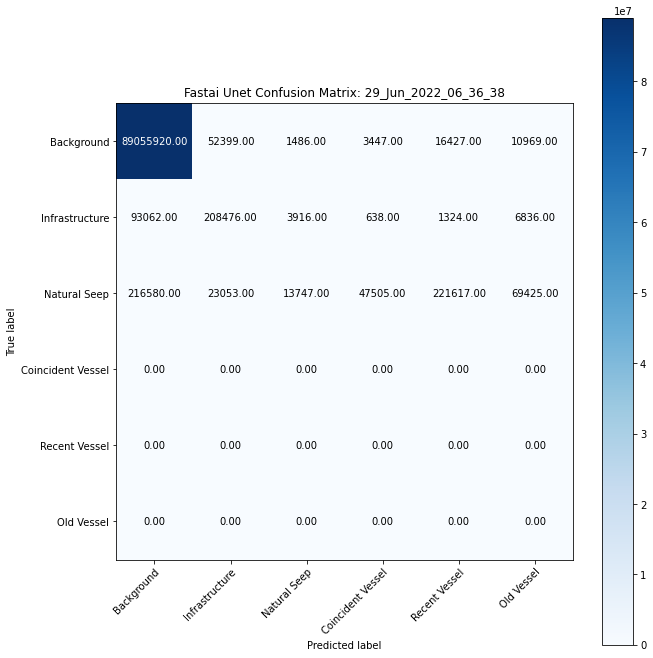

In [55]:
class_names = ["Background"]+list(class_mapping_coco.keys())[:-2]
cm_unet, f1_unet = get_cm_for_torchscript_model_unet(dls, model, fastai_unet_experiment_dir, semantic_mask_conf_thresh=.5, num_classes=6, class_names=class_names, normalize = None, title="Fastai Unet Confusion Matrix: 29_Jun_2022_06_36_38")

In [ ]:
cm_unet, f1_unet = get_cm_for_torchscript_model_unet(dls, model, fastai_unet_experiment_dir, semantic_mask_conf_thresh=.5, num_classes=6, class_names=class_names, normalize = "true", title="Fastai Unet Confusion Matrix: 29_Jun_2022_06_36_38")

The pixel wise mrcnn cm is correct.

In [58]:
from tqdm import tqdm
cm_mrcnn, f1_mrcnn = get_cm_for_torchscript_model_mrcnn(
    valid_ds, scripted_model, save_path=icevision_experiment_dir, mask_conf_threshold=.01, bbox_conf_threshold=.7, num_classes=3, normalize=None, class_names=["background", "infra_slick", "recent_vessel"], title="Torchvision MaskR-CNN Confusion Matrix: 20_Jul_2022_00_14_15"
)


 71%|███████   | 244/344 [01:22<00:33,  2.95it/s]


ValueError: need at least one array to stack

In [ ]:
cm_mrcnn, f1_mrcnn = get_cm_for_torchscript_model_mrcnn(
    valid_ds, scripted_model, save_path=icevision_experiment_dir, mask_conf_threshold=.01, bbox_conf_threshold=.7, num_classes=3, normalize="true", class_names=["background", "infra_slick", "recent_vessel"], title="Torchvision MaskR-CNN Confusion Matrix: 20_Jul_2022_00_14_15"
)


In [ ]:
checkpoint_path = '/root/data/experiments/cv2/20_Jul_2022_00_14_15_icevision_maskrcnn/state_dict_test_28_34_224_58.pt'

class_names = ['Background','Infrastructure', 'Recent Vessel']

checkpoint_and_model = model_from_checkpoint(checkpoint_path, 
    model_name='torchvision.mask_rcnn', 
    backbone_name='resnet34_fpn',
    img_size=224, 
    classes=[
            "background",
            "infra_slick",
            "recent_vessel",
        ],
    is_coco=False)

model = checkpoint_and_model["model"]
model_type = checkpoint_and_model["model_type"]
backbone = checkpoint_and_model["backbone"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]
model_type, backbone, class_map, img_size

infer_dl = model_type.infer_dl(valid_ds, batch_size=1,shuffle=False)

preds = model_type.predict_from_dl(model, infer_dl, keep_images=True, detection_threshold=0.0)

In [ ]:
__all__ = ["COCOMetric", "COCOMetricType"]

from icevision.imports import *
from icevision.utils import *
from icevision.data import *
from icevision.metrics.metric import *


class COCOMetricType(Enum):
    """Available options for `COCOMetric`."""

    bbox = "bbox"
    mask = "segm"
    keypoint = "keypoints"


class COCOMetric(Metric):
    """Wrapper around [cocoapi evaluator](https://github.com/cocodataset/cocoapi)

    Calculates average precision.

    # Arguments
        metric_type: Dependent on the task you're solving.
        print_summary: If `True`, prints a table with statistics.
        show_pbar: If `True` shows pbar when preparing the data for evaluation.
    """

    def __init__(
        self,
        metric_type: COCOMetricType = COCOMetricType.bbox,
        iou_thresholds: Optional[Sequence[float]] = None,
        print_summary: bool = False,
        show_pbar: bool = False,
    ):
        self.metric_type = metric_type
        self.iou_thresholds = iou_thresholds
        self.print_summary = print_summary
        self.show_pbar = show_pbar
        self._records, self._preds = [], []

    def _reset(self):
        self._records.clear()
        self._preds.clear()

    def accumulate(self, preds):
        for pred in preds:
            self._records.append(pred.ground_truth)
            self._preds.append(pred.pred)

    def finalize(self) -> Dict[str, float]:
        with CaptureStdout():
            coco_eval = create_coco_eval(
                records=self._records,
                preds=self._preds,
                metric_type=self.metric_type.value,
                iou_thresholds=self.iou_thresholds,
                show_pbar=self.show_pbar,
            )
            coco_eval.evaluate()
            coco_eval.accumulate()

        with CaptureStdout(propagate_stdout=self.print_summary):
            coco_eval.summarize()

        stats = coco_eval.stats
        logs = {
            "AP (IoU=0.50:0.95) area=all": stats[0],
            "AP (IoU=0.50) area=all": stats[1],
            "AP (IoU=0.75) area=all": stats[2],
            "AP (IoU=0.50:0.95) area=small": stats[3],
            "AP (IoU=0.50:0.95) area=medium": stats[4],
            "AP (IoU=0.50:0.95) area=large": stats[5],
            "AR (IoU=0.50:0.95) area=all maxDets=1": stats[6],
            "AR (IoU=0.50:0.95) area=all maxDets=10": stats[7],
            "AR (IoU=0.50:0.95) area=all maxDets=100": stats[8],
            "AR (IoU=0.50:0.95) area=small maxDets=100": stats[9],
            "AR (IoU=0.50:0.95) area=medium maxDets=100": stats[10],
            "AR (IoU=0.50:0.95) area=large maxDets=100": stats[11],
        }

        self._reset()
        return logs


In [ ]:
preds[0].pred.detection.bboxes[0].xyxy

In [ ]:
preds[0].pred.detection.bboxes[0].xywh

In [ ]:
coco_metric = COCOMetric(print_summary=True)

In [ ]:
coco_metric.accumulate(preds)

In [ ]:
coco_metric.finalize()

In [ ]:
cm = SimpleConfusionMatrix()
cm.accumulate(preds)

TODO highlight edits to icevision cm code and how to and where to install this edited icevision

In [ ]:
%matplotlib inline
_ = cm.finalize()

cm.plot(figsize=5, normalize=None)

In [ ]:
cm.class_map

# TODO make sure cm code for icevision is pred and merged